# Coverage of MultiPLIER LV

The goal of this notebook is to examine why genes were found to be generic. Specifically, this notebook is trying to answer the question: Are generic genes found in more multiplier latent variables compared to specific genes?

The PLIER model performs a matrix factorization of gene expression data to get two matrices: loadings (Z) and latent matrix (B). The loadings (Z) are constrained to aligned with curated pathways and gene sets specified by prior knowledge [Figure 1B of Taroni et. al.](https://www.cell.com/cell-systems/pdfExtended/S2405-4712(19)30119-X). This ensure that some but not all latent variables capture known biology. The way PLIER does this is by applying a penalty such that the individual latent variables represent a few gene sets in order to make the latent variables more interpretable. Ideally there would be one latent variable associated with one gene set unambiguously.

While the PLIER model was trained on specific datasets, MultiPLIER extended this approach to all of recount2, where the latent variables should correspond to specific pathways or gene sets of interest. Therefore, we will look at the coverage of generic genes versus other genes across these MultiPLIER latent variables, which represent biological patterns.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import textwrap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from ponyo import utils
from generic_expression_patterns_modules import process

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Get data directory containing gene summary data
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
data_dir = os.path.join(base_dir, "human_general_analysis")

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]

In [3]:
# Output file
nonzero_figure_filename = "nonzero_LV_coverage.svg"
highweight_figure_filename = "highweight_LV_coverage.svg"

## Load data

In [4]:
# Get gene summary file
ls_data_filename = process.get_gene_summary_file(data_dir)

# Check that there is only one file returned
assert len(ls_data_filename) == 1

In [5]:
# Load gene summary data
data = pd.read_csv(ls_data_filename[0], sep="\t", index_col=0, header=0)

# Check that genes are unique since we will be using them as dictionary keys below
assert(data.shape[0] == len(data["Gene ID"].unique()))

In [6]:
# Load multiplier models
# Converted formatted pickle files (loaded using phenoplier environment) from
# https://github.com/greenelab/phenoplier/blob/master/nbs/01_preprocessing/005-multiplier_recount2_models.ipynb
# into .tsv files
multiplier_model_z = pd.read_csv("multiplier_model_z.tsv", sep="\t", index_col=0, header=0)

In [7]:
# Get a rough sense for how many genes contribute to a given LV
# (i.e. how many genes have a value > 0 for a given LV)
(multiplier_model_z > 0).sum().sort_values(ascending=True)

LV37      174
LV935     282
LV912     299
LV45      401
LV817     414
LV921     498
LV61      680
LV819    1065
LV556    1159
LV13     1426
LV730    1446
LV36     1459
LV249    1510
LV847    1522
LV540    1534
LV12     1563
LV14     1603
LV29     1632
LV5      1668
LV759    1728
LV118    1735
LV536    1793
LV59     1797
LV245    1812
LV42     1831
LV11     1832
LV234    1843
LV765    1852
LV252    1857
LV149    1864
         ... 
LV687    3709
LV282    3715
LV9      3717
LV966    3725
LV367    3732
LV636    3734
LV476    3739
LV940    3747
LV526    3754
LV478    3754
LV974    3761
LV732    3779
LV55     3806
LV835    3910
LV379    3953
LV625    3993
LV607    4015
LV74     4025
LV229    4094
LV976    4128
LV395    4220
LV70     4280
LV987    4285
LV739    4441
LV889    4471
LV841    4504
LV516    4520
LV984    4605
LV915    4640
LV830    5496
Length: 987, dtype: int64

## Get gene data

Define generic genes based on simulated gene ranking. Refer to [figure](https://github.com/greenelab/generic-expression-patterns/blob/master/human_general_analysis/gene_ranking_log2FoldChange.svg) as a guide.

**Definitions:**
* Generic genes: `Rank (simulated) >= 10000` 

(Having a high rank indicates that these genes are consistently changed across simulated experiments.)

* Other genes: `Rank (simulated) < 10000` 

(Having a lower rank indicates that these genes are not consistently changed across simulated experiments - i.e. the genes are specifically changed in an experiment. It could also indicate genes that are consistently unchanged.)

In [8]:
generic_threshold = 10000
dict_genes = process.get_generic_specific_genes(data, generic_threshold)

(17754, 10)
No. of generic genes: 7755
No. of other genes: 9999


In [9]:
# Check overlap between multiplier genes and our genes
multiplier_genes = list(multiplier_model_z.index)
our_genes = list(data.index)
shared_genes = set(our_genes).intersection(multiplier_genes)

print(len(our_genes))
print(len(shared_genes))

17754
6374


In [10]:
# Drop gene ids not used in multiplier analysis
processed_dict_genes = process.process_generic_specific_gene_lists(dict_genes, multiplier_model_z)

In [11]:
# Check numbers add up
assert len(shared_genes) == len(processed_dict_genes["generic"]) + len(processed_dict_genes["other"])

## Get coverage of LVs

For each gene (generic or other) we want to find:
1. The number of LVs that gene is present
2. The number of LVs that the gene contributes a lot to (i.e. the gene is highly weighted within that LV)

### Nonzero LV coverage

In [12]:
dict_nonzero_coverage = process.get_nonzero_LV_coverage(processed_dict_genes, multiplier_model_z)

In [13]:
# Check genes mapped correctly
assert processed_dict_genes["generic"][0] in dict_nonzero_coverage["generic"].index
assert len(dict_nonzero_coverage["generic"]) == len(processed_dict_genes["generic"])
assert len(dict_nonzero_coverage["other"]) == len(processed_dict_genes["other"])

### High weight LV coverage

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


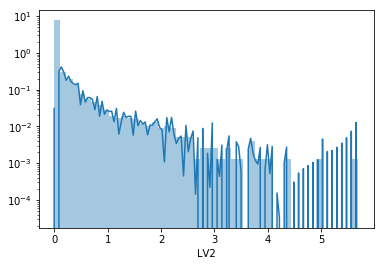

In [14]:
# Quick look at the distribution of gene weights per LV
sns.distplot(multiplier_model_z["LV2"])
plt.yscale("log")

In [15]:
dict_highweight_coverage = process.get_highweight_LV_coverage(processed_dict_genes, multiplier_model_z, 0.9)

In [16]:
# Check genes mapped correctly
assert processed_dict_genes["generic"][0] in dict_highweight_coverage["generic"].index
assert len(dict_highweight_coverage["generic"]) == len(processed_dict_genes["generic"])
assert len(dict_highweight_coverage["other"]) == len(processed_dict_genes["other"])

### Assemble LV coverage and plot

In [17]:
all_coverage = []
for gene_label in dict_genes.keys():
    merged_df = pd.DataFrame(
        dict_nonzero_coverage[gene_label],
        columns= ["nonzero LV coverage"]
    ).merge(
        pd.DataFrame(
            dict_highweight_coverage[gene_label],
            columns= ["highweight LV coverage"]
        ),
        left_index=True,
        right_index=True
    ) 
    merged_df['gene type'] = gene_label
    all_coverage.append(merged_df)

all_coverage_df = pd.concat(all_coverage)

In [18]:
all_coverage_df.head()

,nonzero LV coverage,highweight LV coverage,gene type
TLR4,363,42,generic
VSIG1,429,40,generic
PF4V1,275,6,generic
FZD7,391,65,generic
TNFSF4,345,97,generic


Text(0.5, 1.0, 'Number of LVs genes are present in')

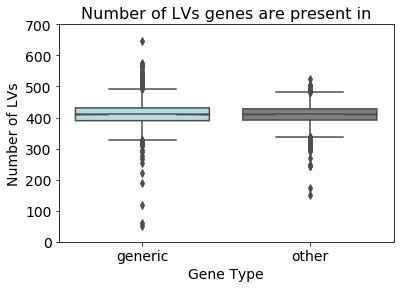

In [19]:
# Plot coverage distribution given list of generic coverage, specific coverage
nonzero_fig = sns.boxplot(
    data=all_coverage_df, 
    x='gene type',
    y='nonzero LV coverage',
    notch=True,
    palette=['powderblue', 'grey']
                         )
plt.ylim(0, 700)
nonzero_fig.set_xlabel("Gene Type",fontsize=14)
nonzero_fig.set_ylabel(textwrap.fill("Number of LVs", width=30),fontsize=14)
nonzero_fig.tick_params(labelsize=14)
nonzero_fig.set_title("Number of LVs genes are present in", fontsize=16)

Text(0.5, 1.0, 'Number of LVs genes contribute highly to')

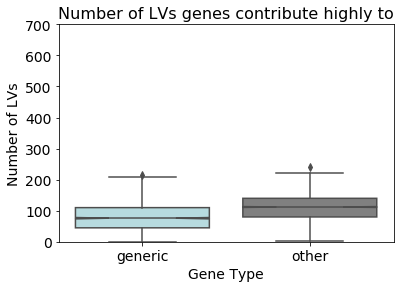

In [20]:
# Plot coverage distribution given list of generic coverage, specific coverage
highweight_fig = sns.boxplot(data=all_coverage_df, 
                             x='gene type',
                             y='highweight LV coverage',
                             notch=True,
                             palette=['powderblue', 'grey']
                            )
plt.ylim(0, 700)
highweight_fig.set_xlabel("Gene Type",fontsize=14)
highweight_fig.set_ylabel(textwrap.fill("Number of LVs", width=30),fontsize=14)
highweight_fig.tick_params(labelsize=14)
highweight_fig.set_title("Number of LVs genes contribute highly to", fontsize=16)

## Get LVs that generic genes are highly weighted in

In [21]:
thresholds_per_LV = multiplier_model_z.quantile(0.9)
gene_ids = processed_dict_genes["generic"]
multiplier_model_z[(multiplier_model_z > thresholds_per_LV)["LV1"] == True]

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
PPIF,1.073451,0.129279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.501172,...,0.035654,0.000000,0.000000,0.000000,0.000000,0.024178,0.238115,0.000000,0.000000,0.507745
CHPF,0.492330,0.000000,0.108949,0.000000,0.000000,0.000000,0.000000,0.033263,2.021536,0.000000,...,0.000000,0.000000,0.001103,0.006737,0.000000,0.005908,0.000000,0.081818,0.000000,0.041570
FOXM1,0.813806,0.003903,0.000000,0.000000,0.000000,0.164531,0.000000,0.000000,0.265652,0.000000,...,0.000000,0.015637,0.073430,0.000000,0.000000,0.000000,0.061530,0.007260,0.000000,0.783440
TRIP10,0.491522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084070,0.426223,0.000000,...,0.169988,0.000000,0.000000,0.000000,0.000000,0.025849,0.453560,0.000000,0.000000,0.236306
ERF,1.637014,0.000000,0.000000,0.000000,0.000000,0.000000,0.494961,0.182715,1.177766,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.036040,0.000000,0.365223,0.024653,0.000014,1.036760
IMPDH1,0.530717,0.373883,0.044615,0.000000,0.000000,0.000000,1.080571,0.000000,0.009484,0.000000,...,0.000000,0.009697,0.000000,0.011545,0.023447,0.033329,0.214409,0.000000,0.000000,0.004074
CPOX,0.521068,0.000000,0.000000,0.280892,0.000000,0.029831,0.000000,0.000000,0.000000,0.014027,...,0.345953,0.093138,0.155197,0.000000,0.000000,0.043611,0.205665,0.000000,0.000000,0.097272
ADA,0.503613,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101162,0.000000,...,0.001361,0.000000,0.000000,0.051012,0.019051,0.000000,0.358473,0.000000,0.000000,0.361169
TRPM2,0.506565,0.313574,1.096522,0.207938,0.000000,0.000000,1.001135,0.000000,0.486682,0.723560,...,0.000000,0.000000,0.000000,0.010198,0.000000,0.011127,0.253554,0.142028,0.078963,0.000000
ICAM4,0.446482,0.076083,0.000000,0.000000,0.144242,0.029512,0.024725,0.000000,0.096571,0.000000,...,0.000000,0.008964,0.000000,0.015415,0.000000,0.000000,0.026307,0.000000,0.000000,0.000000


In [22]:
thresholds_per_LV

LV1      0.442461
LV2      0.177852
LV3      0.310925
LV4      0.324654
LV5      0.045580
LV6      0.159790
LV7      0.155308
LV8      0.183450
LV9      0.697026
LV10     0.113247
LV11     0.063531
LV12     0.057557
LV13     0.084498
LV14     0.060663
LV15     0.355799
LV16     0.244018
LV17     0.113078
LV18     0.102849
LV19     0.151971
LV20     0.286134
LV21     0.096519
LV22     0.161463
LV23     0.133930
LV24     0.141166
LV25     0.096631
LV26     0.061720
LV27     0.131280
LV28     0.188473
LV29     0.015663
LV30     0.108732
           ...   
LV958    0.181280
LV959    0.081074
LV960    0.103906
LV961    0.045841
LV962    0.113581
LV963    0.095533
LV964    0.204915
LV965    0.131835
LV966    0.130280
LV967    0.104468
LV968    0.072569
LV969    0.092395
LV970    0.115052
LV971    0.067026
LV972    0.047840
LV973    0.067515
LV974    0.280254
LV975    0.162561
LV976    0.398317
LV977    0.099481
LV978    0.121415
LV979    0.084235
LV980    0.094533
LV981    0.056646
LV982    0

## Save

In [23]:
# Save plot
nonzero_fig.figure.savefig(
        nonzero_figure_filename,
        format="svg",
        bbox_inches="tight",
        transparent=True,
        pad_inches=0,
        dpi=300,
    )

# Save plot
highweight_fig.figure.savefig(
        highweight_figure_filename,
        format="svg",
        bbox_inches="tight",
        transparent=True,
        pad_inches=0,
        dpi=300,
    )

**Takeaway:**
* Generic and other genes have are present in a similar number of LVs. This isn't surprising since the number of genes that contribute to each LV is <1000.
* Other genes are highly weighted in more LVs compared to generic genes
* So, generic genes contribute a little to many LVs versus other genes that contribute a lot to some LVs
* The LVs that were found to contribute alot to can be found in [table](generic_only_LV_summary.tsv). These LVs include -------mainly immune response pathways (monocytes, mast cell activation), wound healing (collagen formation), cell signaling (focal adhesion, integrin1) 

**Overall, it looks like generic genes are associated with many pathways, acting as *gene hubs*, which is why they are "generic"**